#### Steps to setup Openbb SDK in Jupyter notebook

1. Check conda version

    $ conda --version 

2. Update conda recommended

    $ conda update -n base -c conda-forge conda

3. Setup and activate the `meta-labell` environment

    $ conda env create --file=environment.yaml

    $ conda activate meta-labell    

4. Install openbb sdk
    
    $ pip install "openbb" --no-cache-dir              

In [3]:
from openbb_terminal.sdk import openbb
# Show trending coins
openbb.crypto.disc.trending()

,Symbol,Name,market_cap Cap Rank
0,bitcoin,Bitcoin,1
1,bonk,Bonk,942
2,apecoin,ApeCoin,80
3,trust-wallet-token,Trust Wallet,97
4,unibot,Unibot,257
5,arbitrum,Arbitrum,43
6,solana,Solana,10


In [4]:
import pandas as pd
from openbb_terminal.sdk import openbb
%matplotlib inline

In [5]:
trades_ethusdt = openbb.crypto.dd.trades(exchange_id = 'coinbaseprime', symbol = 'ETH', to_symbol = 'USDT')

trades_ethusdt.tail(5)

,Date,Price,Amount,Cost,Side
995,2023-09-11 20:39:27.931000+00:00,1542.94,0.080000,123.435200,sell
996,2023-09-11 20:39:28.009000+00:00,1543.05,0.080000,123.444000,sell
997,2023-09-11 20:39:28.009000+00:00,1543.05,0.080000,123.444000,sell
998,2023-09-11 20:39:42.596000+00:00,1543.19,0.284890,439.639399,sell
999,2023-09-11 20:39:42.610000+00:00,1543.04,1.620822,2500.992778,sell


In [14]:
btc_df = openbb.crypto.load(symbol="btc",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
btc_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2023-09-06,25783.931641,25953.015625,25404.359375,25753.236328,25753.236328,12752705327
2023-09-07,25748.312500,26409.302734,25608.201172,26240.195312,26240.195312,11088307100
2023-09-08,26245.208984,26414.005859,25677.480469,25905.654297,25905.654297,10817356400
2023-09-09,25905.425781,25921.976562,25810.494141,25895.677734,25895.677734,5481314132
2023-09-10,25895.210938,25978.130859,25640.261719,25832.226562,25832.226562,7899553047


Text(0.0, 1.0, 'BTC Price Over Time')

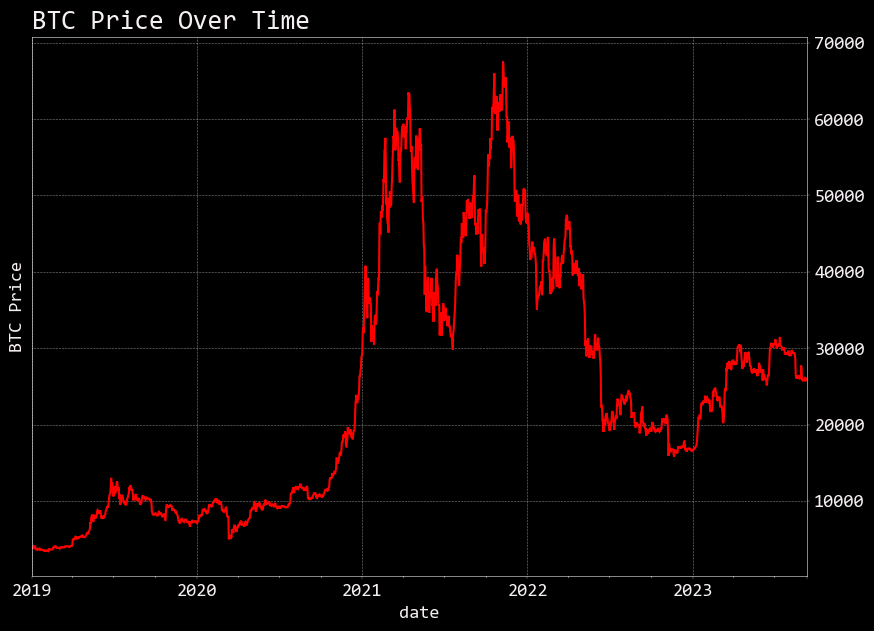

In [15]:
# Plot the Adj Close price overtime with a simple forecasting of the price for five days in the future 
import matplotlib.pyplot as plt

btc_df['Adj Close'].plot(figsize=(10, 7), color='r')
plt.ylabel('BTC Price')
plt.title('BTC Price Over Time')
